In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
# import seaborn as sns
# sns.set(0)
import numpy.random as rnd
%matplotlib inline

In [2]:
edges = np.loadtxt("fb_Princeton.txt", skiprows=4, dtype="i8,i8")
G = nx.Graph()
G.add_edges_from(edges)

In [3]:
k = nx.degree(G)
e = nx.edges(G)

common information about Graph:
number of vertices and edges; number of conntected components:

In [8]:
degrees = np.array(list(dict(k).values()))
len(degrees), len(e), nx.number_connected_components(G)

(6596, 293320, 10)

Distribution of degrees:

Text(0.5,0,'x')

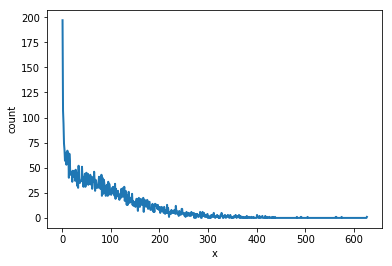

In [9]:
yh0, binEdges=np.histogram(degrees, bins=627)
bincenters0 = 0.5*(binEdges[1:]+binEdges[:-1])
plt.plot(np.arange(1, max(degrees)), yh0, '-', lw=2)
plt.ylabel('count')
plt.xlabel('x')

Plot pdf

Text(0.5,0,'x')

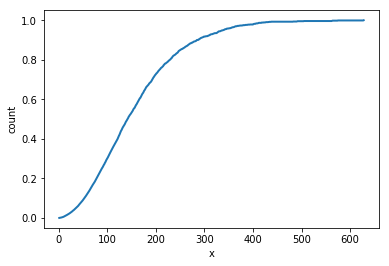

In [10]:
cdf = []
for cur_degree in range(1, max(degrees) + 1):
    cdf.append(sum([x if x <= cur_degree else 0 for x in degrees]))
cdf = [i / max(cdf) for i in cdf]
plt.plot(np.arange(1, max(degrees) + 1), cdf, '-', lw=2)
plt.ylabel('count')
plt.xlabel('x')

# Task 1

Degree distribution in loglog-scale

Text(0.5,0,'x')

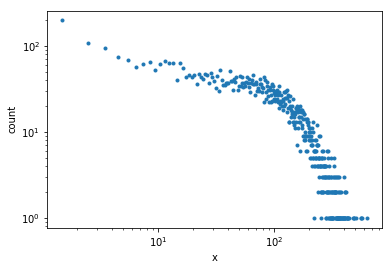

In [11]:
plt.loglog(bincenters0, yh0, '.', lw=2)
plt.ylabel('count')
plt.xlabel('x')

That distribution isn't nice. Let's take some value for xmin to build a regression:

In [12]:
my_xmin_index = 55

In [13]:
bincenters = bincenters0[55:]
yh = yh0[55:]

Text(0.5,1,'Estimated $\\alpha$ = -2.0972')

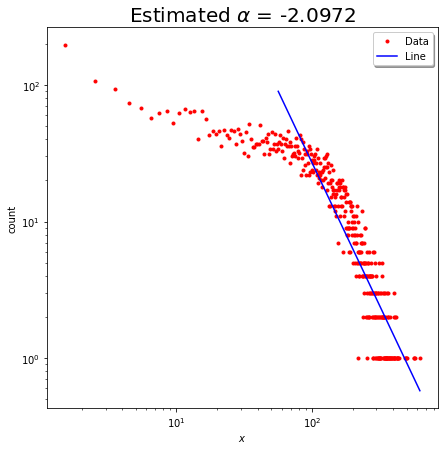

In [14]:
idx = np.ix_(yh != 0)
x_est = np.log(bincenters[idx])
y_est = np.log(yh[idx])
s = len(x_est)

# Do estimation
X = np.vstack([np.ones(s), x_est]).T
Beta = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y_est)

# Plot
idx = np.argsort(x_est)
yt = np.exp(X[idx,:].dot(Beta))
xt = np.exp(X[idx,1])

fig, ax = plt.subplots()
fig.set_size_inches(7,7)
ax.loglog(bincenters0, yh0, '.r', label='Data') 
ax.loglog(xt, yt, 'b', label='Line')
plt.ylabel('count')
plt.xlabel('$x$')
ax.legend(loc='upper right', shadow=True)
plt.title('Estimated $\\alpha$ = {0:1.4f}'.format(Beta[1]), fontsize=20)

$b$ and $k$ coefficients of linear regression ($k*x + b$)

In [15]:
Beta

array([ 12.9585665 ,  -2.09717025])

Linear regression of x looks like $log(x)=-\alpha log(x) + log(C)$, so:

In [16]:
C = np.exp(Beta[0])
alpha = -Beta[1]

$x_{min}=(\frac{C}{\alpha - 1})^{\frac1{\alpha-1}}$, so:

In [17]:
xmin = (C / (alpha - 1)) ** (1 / (alpha - 1))
xmin, alpha, C

(123794.36363325737, 2.0971702524077962, 424457.2195691712)

Easy to see, that this $x_{min}$ is not good; obviously this value is greater than any degree from graph. However, we have found suitable alpha

# Task 2

Anyway, we are able to find max and average number of in- and out- edges. Graph is undirected, so parameters for in- and out- edges is equal.

In [18]:
max(degrees), np.mean(degrees)

(628, 88.938750758035169)

# Task 3

We know $x_min$, so it is easy to find $\alpha$ by formula $\alpha = 1 + n[\sum_{i=1}^n ln(\frac{x_i}{x_{min}})]^{-1}$

In [19]:
def find_alpha(degrees, xmin):
    sum_degree = sum([np.log(xi/xmin) if xi > xmin else 0 for xi in degrees])
    alpha = 1 + len(degrees) * sum_degree ** (-1)
    return alpha

Now we can take some xmin (35, for example) and find alpha:

In [20]:
find_alpha(degrees, 35)

2.3285634905403225

# Task 4

Now we are going to take different xmin; for each of them alpha and C are easy to find with:

$\alpha = 1 + n[\sum_{i=1}^n ln(\frac{x_i}{x_{min}})]^{-1}$

$C = (\alpha - 1) \cdot x_{min}^{(\alpha - 1)}$

After this analytical CDF is easy to compute by formula $F_x=1-\frac{x_{min}}{x}^{\alpha -1}$ and be compared with empirical (which is called cdf in my notebook)

In [23]:
minmaxdiff = 99999999
for xmin in range(1, max(degrees)):
    alpha = find_alpha(degrees, xmin)
    C = (alpha - 1) * (xmin ** (alpha - 1))
    max_diff = 0
    for x in range(1, max(degrees)):
        if xmin < x:
            Fx = 1 - (xmin / x) ** (alpha-1)
        else:
            Fx = 0
        cur_diff = np.absolute(Fx - cdf[x-1])
        if max_diff < cur_diff:
            max_diff = cur_diff
            cur_x = x
    print("xmin =",xmin, "max_diff=", max_diff, "alpha = ", alpha, "C = ", C)
    if minmaxdiff > max_diff and max_diff > 0 and max_diff != np.inf:
        minmaxdiff = max_diff
        best_alpha, best_C, best_xmin, best_x = alpha, C, xmin, cur_x


xmin = 1 max_diff= 0.548442842365 alpha =  1.255330766 C =  0.255330765998
xmin = 2 max_diff= 0.541191262585 alpha =  1.30825729827 C =  0.381687608558
xmin = 3 max_diff= 0.536132659869 alpha =  1.34998498778 C =  0.514084716479
xmin = 4 max_diff= 0.532127289013 alpha =  1.38655679777 C =  0.660607800018
xmin = 5 max_diff= 0.528522793504 alpha =  1.42020934117 C =  0.826379295215
xmin = 6 max_diff= 0.524918256948 alpha =  1.4520037678 C =  1.01594302289
xmin = 7 max_diff= 0.521758812645 alpha =  1.48258534228 C =  1.23425829238
xmin = 8 max_diff= 0.518944934882 alpha =  1.51229982067 C =  1.4865415146
xmin = 9 max_diff= 0.516287393661 alpha =  1.54138123653 C =  1.77873884457
xmin = 10 max_diff= 0.513511962612 alpha =  1.57006757628 C =  2.1183314626
xmin = 11 max_diff= 0.510666857721 alpha =  1.59844722869 C =  2.51330055175
xmin = 12 max_diff= 0.508241505854 alpha =  1.62659340072 C =  2.97299147265
xmin = 13 max_diff= 0.505946812714 alpha =  1.65460131237 C =  3.50885685993
xmin = 1

xmin = 175 max_diff= 0.63945008864 alpha =  26.6920446827 C =  1.09152186698e+59
xmin = 176 max_diff= 0.644550320469 alpha =  27.2014596107 C =  1.79487809052e+60
xmin = 177 max_diff= 0.647265784808 alpha =  27.7179928616 C =  3.07707097145e+61
xmin = 178 max_diff= 0.651513705168 alpha =  28.2465059122 C =  5.64147560168e+62
xmin = 179 max_diff= 0.656395745261 alpha =  28.784025798 C =  1.08923579611e+64
xmin = 180 max_diff= 0.661305059321 alpha =  29.329154005 C =  2.19885061625e+65
xmin = 181 max_diff= 0.664081890086 alpha =  29.8816834349 C =  4.6363946982e+66
xmin = 182 max_diff= 0.666563821083 alpha =  30.4464465807 C =  1.0473800301e+68
xmin = 183 max_diff= 0.669059389063 alpha =  31.0244633675 C =  2.54891362193e+69
xmin = 184 max_diff= 0.671882244647 alpha =  31.6160887232 C =  6.69596413769e+70
xmin = 185 max_diff= 0.675035797082 alpha =  32.2208858227 C =  1.8947629939e+72
xmin = 186 max_diff= 0.679474635211 alpha =  32.8383124349 C =  5.75986405479e+73
xmin = 187 max_diff= 0

C:\Users\Victoria\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.


216.04447264 C =  inf
xmin = 287 max_diff= 0.900507977635 alpha =  220.235727436 C =  inf
xmin = 288 max_diff= 0.901489840447 alpha =  224.578148255 C =  inf
xmin = 289 max_diff= 0.904445656621 alpha =  229.025430552 C =  inf
xmin = 290 max_diff= 0.905434337924 alpha =  233.466993096 C =  inf
xmin = 291 max_diff= 0.906922473749 alpha =  238.010163219 C =  inf
xmin = 292 max_diff= 0.909411223237 alpha =  242.626792223 C =  inf
xmin = 293 max_diff= 0.910410132279 alpha =  247.252855058 C =  inf
xmin = 294 max_diff= 0.910911291422 alpha =  251.977724747 C =  inf
xmin = 295 max_diff= 0.912419882722 alpha =  256.836758634 C =  inf
xmin = 296 max_diff= 0.913429019501 alpha =  261.765521072 C =  inf
xmin = 297 max_diff= 0.913935292513 alpha =  266.798039245 C =  inf
xmin = 298 max_diff= 0.915459225419 alpha =  271.973274989 C =  inf
xmin = 299 max_diff= 0.917497954452 alpha =  277.219357059 C =  inf
xmin = 300 max_diff= 0.917497954452 alpha =  282.493479124 C =  inf
xmin = 301 max_diff= 0.917

xmin = 474 max_diff= 0.992668416746 alpha =  6765.5492946 C =  inf
xmin = 475 max_diff= 0.992668416746 alpha =  6884.57093793 C =  inf
xmin = 476 max_diff= 0.992668416746 alpha =  7007.5920369 C =  inf
xmin = 477 max_diff= 0.992668416746 alpha =  7134.81791164 C =  inf
xmin = 478 max_diff= 0.992668416746 alpha =  7266.46817972 C =  inf
xmin = 479 max_diff= 0.992668416746 alpha =  7402.77802272 C =  inf
xmin = 480 max_diff= 0.992668416746 alpha =  7543.99958988 C =  inf
xmin = 481 max_diff= 0.992668416746 alpha =  7690.40355635 C =  inf
xmin = 482 max_diff= 0.992668416746 alpha =  7842.28085655 C =  inf
xmin = 483 max_diff= 0.993491749625 alpha =  7999.94461568 C =  inf
xmin = 484 max_diff= 0.993491749625 alpha =  8142.89296607 C =  inf
xmin = 485 max_diff= 0.993491749625 alpha =  8290.73218339 C =  inf
xmin = 486 max_diff= 0.993491749625 alpha =  8443.71797371 C =  inf
xmin = 487 max_diff= 0.993491749625 alpha =  8602.12418306 C =  inf
xmin = 488 max_diff= 0.993491749625 alpha =  8766.

xmin = 597 max_diff= 0.998929496795 alpha =  130297.368932 C =  inf
xmin = 598 max_diff= 0.998929496795 alpha =  134752.361881 C =  inf
xmin = 599 max_diff= 0.998929496795 alpha =  139514.530756 C =  inf
xmin = 600 max_diff= 0.998929496795 alpha =  144616.787434 C =  inf
xmin = 601 max_diff= 0.998929496795 alpha =  150096.919622 C =  inf
xmin = 602 max_diff= 0.998929496795 alpha =  155998.528521 C =  inf
xmin = 603 max_diff= 0.998929496795 alpha =  162372.191522 C =  inf
xmin = 604 max_diff= 0.998929496795 alpha =  169276.915581 C =  inf
xmin = 605 max_diff= 0.998929496795 alpha =  176781.969734 C =  inf
xmin = 606 max_diff= 0.998929496795 alpha =  184969.217385 C =  inf
xmin = 607 max_diff= 0.998929496795 alpha =  193936.114965 C =  inf
xmin = 608 max_diff= 0.998929496795 alpha =  203799.610193 C =  inf
xmin = 609 max_diff= 0.998929496795 alpha =  214701.271357 C =  inf
xmin = 610 max_diff= 0.998929496795 alpha =  226814.126365 C =  inf
xmin = 611 max_diff= 0.998929496795 alpha =  240

In [24]:
print("xmin =", best_xmin, "max_diff=", minmaxdiff, "alpha = ", best_alpha, "C = ", best_C)

xmin = 111 max_diff= 0.355845886501 alpha =  8.14986805377 C =  3.00668169051e+15


Unfortunately, C became too high to calculate further. However, $x_{min}$ is found and it is 111.